In [19]:
import os, glob, re
import pandas as pd

Corpora

In [20]:
CORPORA = {
    "Folk Fairy Tales": r"C:\Users\Sophia\Downloads\MA\CORPORA\German FFT",
    "GPT-5":            r"C:\Users\Sophia\Downloads\MA\CORPORA\GPT-5",
    "GPT-4o":           r"C:\Users\Sophia\Downloads\MA\CORPORA\GPT-4o",
}

OUTDIR = r"C:\Users\Sophia\Downloads\MA\TABLES\Direct Speech"

Find direct speech

In [21]:
FILE_PATTERN = "**/*.txt"

def direct_speech_char_share(text: str):
    matches = re.finditer(r'"(.*?)"', text, flags=re.DOTALL)
    chars_in_quotes = sum(len(m.group(1)) for m in matches)
    total_chars = len(text)
    share = 0.0 if total_chars == 0 else 100.0 * chars_in_quotes / total_chars
    return round(share, 2), chars_in_quotes, total_chars

rows = []
for corpus_name, corpus_dir in CORPORA.items():
    for fp in glob.glob(os.path.join(corpus_dir, FILE_PATTERN), recursive=True):
        try:
            with open(fp, "r", encoding="utf-8") as f:
                txt = f.read()
        except Exception as e:
            print(f"[WARN] {fp}: {e}")
            continue

        share, inq, tot = direct_speech_char_share(txt)
        rows.append({
            "corpus": corpus_name,
            "doc": os.path.basename(fp),
            "direct_speech_char_percent": share,  
            "chars_in_quotes": inq,
            "chars_total": tot,
        })

df = pd.DataFrame(rows)

os.makedirs(OUTDIR, exist_ok=True)
per_doc_path = os.path.join(OUTDIR, "direct_speech_char_per_doc.csv")
df.to_csv(per_doc_path, index=False, sep=";", decimal=",", float_format="%.8f", encoding="utf-8")
print(f"[OK] Gespeichert: {per_doc_path}")

summary = (df.groupby("corpus")["direct_speech_char_percent"]
             .agg(["count", "mean", "min", "max"])
             .rename(columns={
                 "count": "docs",
                 "mean":  "mean_direct_speech_char_percent",
                 "min":   "min_percent",
                 "max":   "max_percent"
             })
             .reset_index())

for c in ["mean_direct_speech_char_percent", "min_percent", "max_percent"]:
    summary[c] = summary[c].round(2)

sum_path = os.path.join(OUTDIR, "direct_speech_char_summary_by_corpus.csv")
summary.to_csv(sum_path, index=False, sep=";", decimal=",", float_format="%.8f", encoding="utf-8")
print(f"[OK] Gespeichert: {sum_path}")

print("\nZusammenfassung je Korpus ===")
print(summary.to_string(index=False))

[OK] Gespeichert: C:\Users\Sophia\Downloads\MA\TABLES\Direct Speech\direct_speech_char_per_doc.csv
[OK] Gespeichert: C:\Users\Sophia\Downloads\MA\TABLES\Direct Speech\direct_speech_char_summary_by_corpus.csv

Zusammenfassung je Korpus ===
          corpus  docs  mean_direct_speech_char_percent  min_percent  max_percent
Folk Fairy Tales   122                            26.32         1.15        71.99
          GPT-4o   100                            19.24         5.40        35.38
           GPT-5   100                            20.80         8.66        32.69


FIGURES

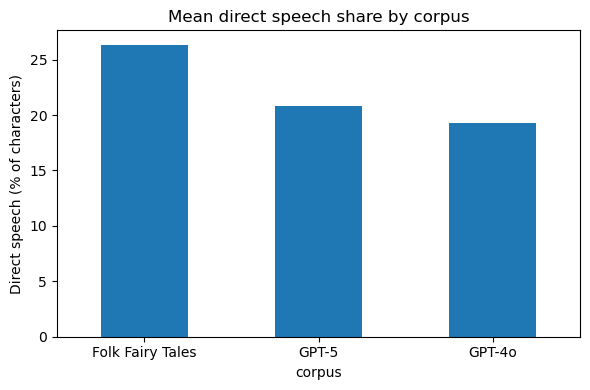

[OK] Plot gespeichert: C:\Users\Sophia\Downloads\MA\TABLES\Direct Speech\direct_speech_mean_by_corpus.png


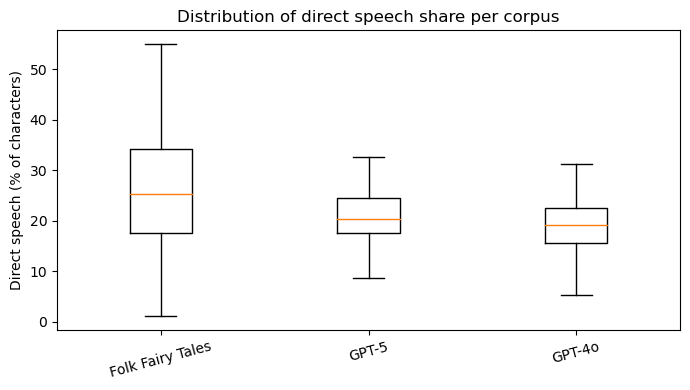

[OK] Plot gespeichert: C:\Users\Sophia\Downloads\MA\TABLES\Direct Speech\direct_speech_boxplot_by_corpus.png


In [22]:
import matplotlib.pyplot as plt

# bar plot
means = (
    df.groupby("corpus")["direct_speech_char_percent"]
      .mean()
      .sort_values(ascending=False)
)

plt.figure(figsize=(6, 4))
means.plot(kind="bar")
plt.ylabel("Direct speech (% of characters)")
plt.title("Mean direct speech share by corpus")
plt.xticks(rotation=0)
plt.tight_layout()
mean_png = os.path.join(OUTDIR, "direct_speech_mean_by_corpus.png")
plt.savefig(mean_png, dpi=200)
plt.show()
print(f"[OK] Plot gespeichert: {mean_png}")

# boxplot
corpus_order = list(CORPORA.keys())
box_data = [df.loc[df["corpus"] == c, "direct_speech_char_percent"].values
            for c in corpus_order]

plt.figure(figsize=(7, 4))
plt.boxplot(box_data, labels=corpus_order, showfliers=False)
plt.ylabel("Direct speech (% of characters)")
plt.title("Distribution of direct speech share per corpus")
plt.xticks(rotation=15)
plt.tight_layout()
box_png = os.path.join(OUTDIR, "direct_speech_boxplot_by_corpus.png")
plt.savefig(box_png, dpi=200)
plt.show()
print(f"[OK] Plot gespeichert: {box_png}")